# Capstone Project
### Machine Learning Engineer Nanodegree
## West Nile Virus Prediction

Kiyoko Ikeuchi, August 3, 2016

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import callables as cl
%matplotlib inline
from IPython.display import display

pd.set_option('display.max_columns', 50)

# Load data
train = pd.read_csv('../input/train.csv')
weather = pd.read_csv('../input/weather.csv', na_values=['M', '-', ' '])

# Inspect the content of the dataset
display(train.head(), train.shape)
display(weather.columns.values, weather.shape)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


(10506, 12)

array(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'], dtype=object)

(2944, 22)

# Data Exploration

Initial exploration of the data through statistics.
Data shows that:
* There are 10506 data points in the training dataset
* Virus is present in <25% of the data
* Some address-related texts and AddressAccuracy can be dropped as >75% of the data have score >= 8
* There are 7 species of mosquitos
* Some columns are object datatype - needs to be addressed before the model application

In [2]:
# Check the statistic of the training data
display(train.describe())
display(train.Species.unique())

# Exclude redundant columns from the training data
train_drop = ['Address', 'AddressNumberAndStreet', 'AddressAccuracy']
train = train.drop(train_drop, axis=1)

# Check data types
display(train.dtypes)
display(weather.dtypes)

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

Date             object
Species          object
Block             int64
Street           object
Trap             object
Latitude        float64
Longitude       float64
NumMosquitos      int64
WnvPresent        int64
dtype: object

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg           float64
Depart         float64
DewPoint         int64
WetBulb        float64
Heat           float64
Cool           float64
Sunrise        float64
Sunset         float64
CodeSum         object
Depth          float64
Water1         float64
SnowFall        object
PrecipTotal     object
StnPressure    float64
SeaLevel       float64
ResultSpeed    float64
ResultDir        int64
AvgSpeed       float64
dtype: object

### Weather Data Missing Data
Check for missing data and fill them accordingly.

In [3]:
# Count the number of missing data by column
for column in weather.columns:
    print column, weather[column].isnull().values.sum()

# Count the number of missing data by station
print 1472 - weather.groupby('Station').count()

# Drop columns with high count of missing data in both stations and unimputable Station2 data
weather_drop = ['Water1', 'CodeSum']
weather = weather.drop(weather_drop, axis=1)

# Impute 'T' (trace) precipitation with zero
weather.replace('  T', 0.0, inplace=True)
# Convert PrecipTotal to real number
weather['PrecipTotal'] = weather['PrecipTotal'].astype(float)

# Impute missing data with median for: Tavg, WetBulb, Heat, Cool, PrecipTotal, StnPressure, SeaLevel, AvgSpeed
weather_impute = ['Tavg', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
# Data statistics before imputation
pd.set_option('chained_assignment',None)
display(weather[weather_impute].describe())
for col in weather_impute:
    median = weather[col].median()
    weather[col].loc[weather[col].isnull()] = median
# Data statistics after imputation
display(weather[weather_impute].describe())

# Verify all missing data has been accounted for
for column in weather.columns:
    print column, weather[column].isnull().values.sum()

# First 5 rows of the final weather data
display(weather.head())

Station 0
Date 0
Tmax 0
Tmin 0
Tavg 11
Depart 1472
DewPoint 0
WetBulb 4
Heat 11
Cool 11
Sunrise 1472
Sunset 1472
CodeSum 1609
Depth 1472
Water1 2944
SnowFall 1472
PrecipTotal 2
StnPressure 4
SeaLevel 9
ResultSpeed 0
ResultDir 0
AvgSpeed 3
         Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  \
Station                                                                  
1           0     0     0     0       0         0        3     0     0   
2           0     0     0    11    1472         0        1    11    11   

         Sunrise  Sunset  CodeSum  Depth  Water1  SnowFall  PrecipTotal  \
Station                                                                   
1              0       0      805      0    1472         0            0   
2           1472    1472      804   1472    1472      1472            2   

         StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
Station                                                           
1                  2         

,Tavg,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,AvgSpeed
count,2933.000000,2940.000000,2933.000000,2933.000000,2942.000000,2940.000000,2935.000000,2941.000000
mean,67.240027,59.310884,3.407092,5.647119,0.131329,29.284429,29.968129,8.580449
std,10.545442,9.286742,5.953203,6.105087,0.393327,0.158543,0.158597,3.147300
min,36.000000,32.000000,0.000000,0.000000,0.000000,28.550000,29.230000,1.700000
25%,60.000000,53.000000,0.000000,0.000000,0.000000,29.190000,29.870000,6.300000
50%,69.000000,61.000000,0.000000,4.000000,0.000000,29.280000,29.970000,8.100000
75%,75.000000,67.000000,5.000000,10.000000,0.060000,29.390000,30.060000,10.400000
max,94.000000,78.000000,29.000000,29.000000,6.860000,29.860000,30.530000,26.300000


,Tavg,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,AvgSpeed
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,67.246603,59.313179,3.394361,5.640965,0.131240,29.284423,29.968135,8.579959
std,10.526264,9.280637,5.945704,6.094496,0.393208,0.158436,0.158354,3.145733
min,36.000000,32.000000,0.000000,0.000000,0.000000,28.550000,29.230000,1.700000
25%,60.000000,53.000000,0.000000,0.000000,0.000000,29.190000,29.870000,6.300000
50%,69.000000,61.000000,0.000000,4.000000,0.000000,29.280000,29.970000,8.100000
75%,75.000000,67.000000,5.000000,10.000000,0.060000,29.390000,30.060000,10.400000
max,94.000000,78.000000,29.000000,29.000000,6.860000,29.860000,30.530000,26.300000


Station 0
Date 0
Tmax 0
Tmin 0
Tavg 0
Depart 1472
DewPoint 0
WetBulb 0
Heat 0
Cool 0
Sunrise 1472
Sunset 1472
Depth 1472
SnowFall 1472
PrecipTotal 0
StnPressure 0
SeaLevel 0
ResultSpeed 0
ResultDir 0
AvgSpeed 0


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0.0,0.0,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,NaN,51,57.0,0.0,3.0,NaN,NaN,NaN,NaN,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,0.0,0.0,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,NaN,42,47.0,13.0,0.0,NaN,NaN,NaN,NaN,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [4]:
# Convert Date to datetime format and add Year & Month columns
files = [train, weather]
for file in files:
    file['Date'] = pd.to_datetime(file['Date'], format='%Y-%m-%d')
    file['Year'] = file['Date'].dt.year
    file['Month'] = file['Date'].dt.month
    file['Day'] = file['Date'].dt.day

### Visualization Locations on the Map
Modified from Kaggle's starter code showing:
* Trap locations in Blue. Bubble size by number of mosquitos x 2.
* Weather stations in Red 

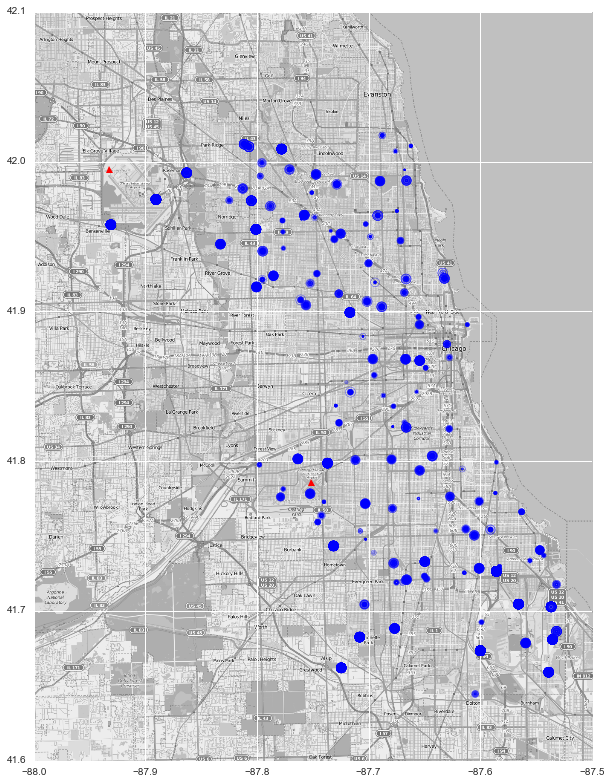

In [5]:
# Map trap and weather station locations on the map of Chicago
cl.Map(train)

### Visualizing the Weather Data
* No obvious outlier
* Data is evenly distributed among the stations
* Temperature and DewPoint are correlated to one another and bary by month
* Precipitation and pressure do not correlate to other parameters or the month

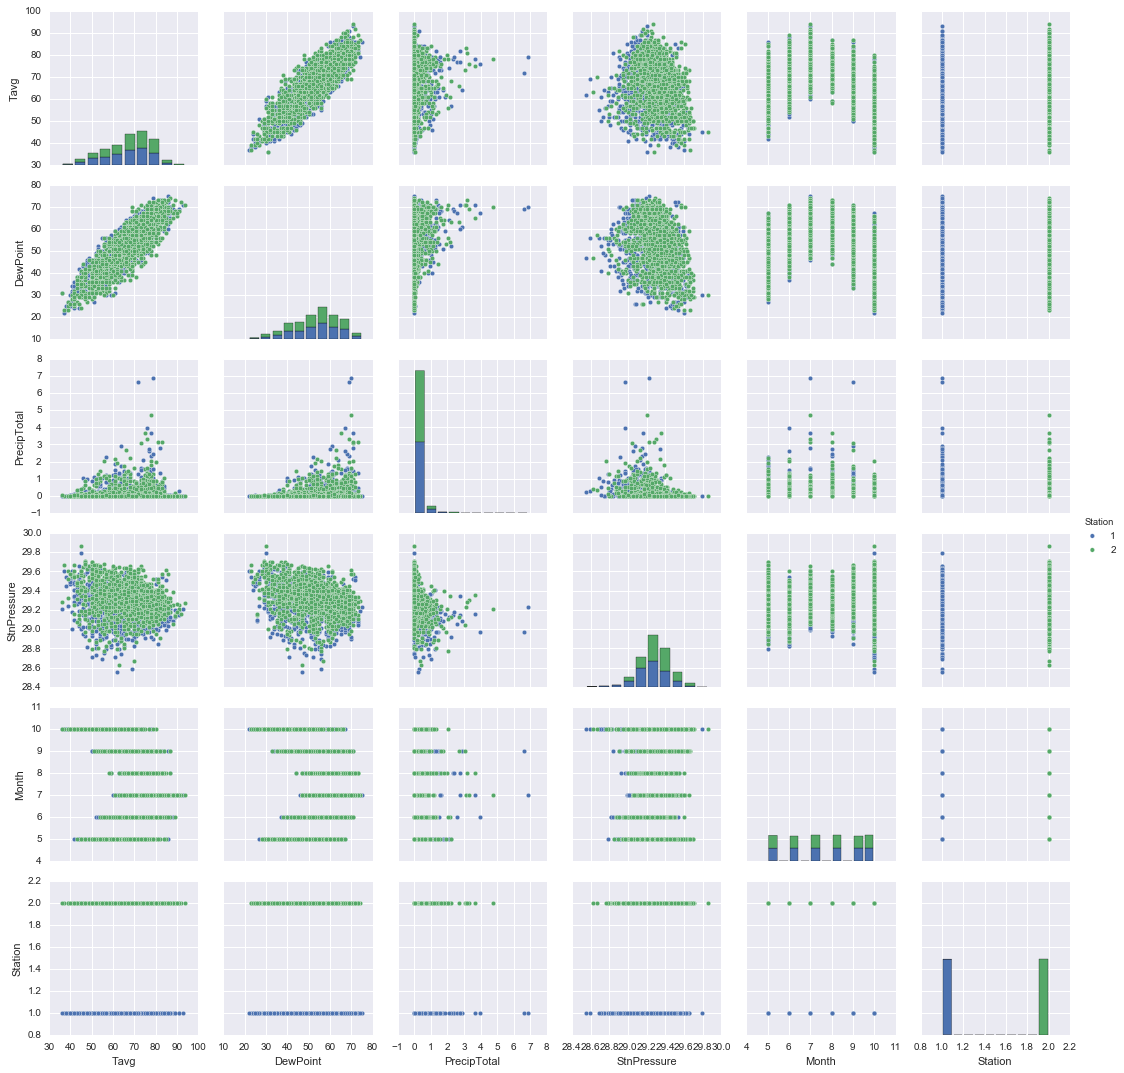

In [6]:
var = ['Tavg', 'DewPoint', 'PrecipTotal', 'StnPressure', 'Month', 'Station']
sns.pairplot(weather[var], hue='Station')
plt.savefig('../working/pairplot.png')

### Visualizing Virus Presence Trend
Visualize virus presence to see what affects the occurrence:
* Year-dependence exists.Virus presence decreased in 2009, but increased in 2011 and outbreak in 2013.
* Month-dependence exists.Virus presence tends to be high in the summer/early fall months.
* Some species seem to be more prone to having the virus.
* Large variation of virus by Trap and Block.

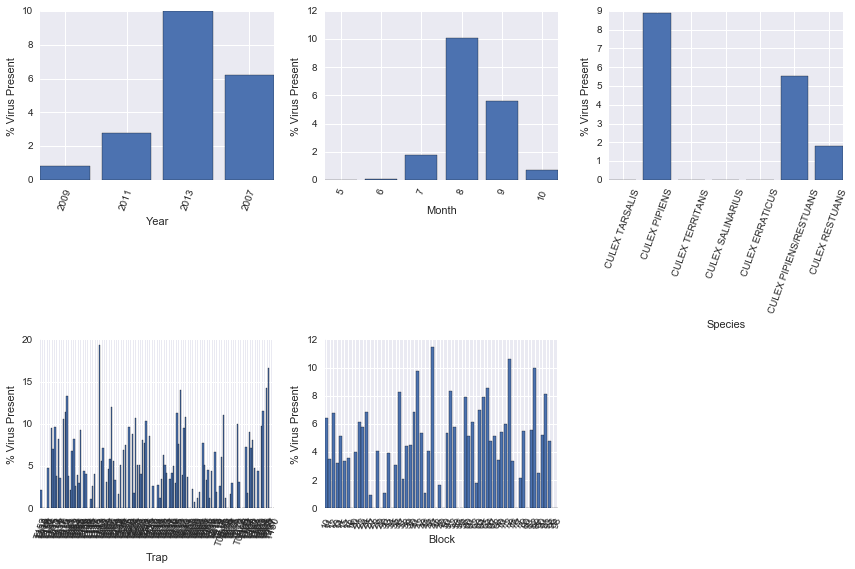

In [7]:
fig = plt.figure(figsize=(12,8))
groups = ['Year', 'Month', 'Species', 'Trap', 'Block']
cl.PercPos(fig, train, groups)
fig.tight_layout()
fig.show()
plt.savefig('../working/histograms.png')

# Data Processing
Prepare the data for modeling:
* Combine Station1 & Station2 weather data by Date
* Combine Train and Weather data by Date
* Process Categorical Featues
* Identify features and labels

In [8]:
# Combine Station1 & Station2 weather data by Date
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

display(weather.head())

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,Sunset_x,Depth_x,SnowFall_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x,Year_x,Month_x,Day_x,Tmax_y,Tmin_y,Tavg_y,Depart_y,DewPoint_y,WetBulb_y,Heat_y,Cool_y,Sunrise_y,Sunset_y,Depth_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y,Year_y,Month_y,Day_y
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,0.0,0.0,0.0,29.10,29.82,1.7,27,9.2,2007,5,1,84,52,68.0,NaN,51,57.0,0.0,3.0,NaN,NaN,NaN,NaN,0.0,29.18,29.82,2.7,25,9.6,2007,5,1
1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,0.0,0.0,0.0,29.38,30.09,13.0,4,13.4,2007,5,2,60,43,52.0,NaN,42,47.0,13.0,0.0,NaN,NaN,NaN,NaN,0.0,29.44,30.08,13.3,2,13.4,2007,5,2
2,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,1851.0,0.0,0.0,0.0,29.39,30.12,11.7,7,11.9,2007,5,3,67,48,58.0,NaN,40,50.0,7.0,0.0,NaN,NaN,NaN,NaN,0.0,29.46,30.12,12.9,6,13.2,2007,5,3
3,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,444.0,1852.0,0.0,0.0,0.0,29.31,30.05,10.4,8,10.8,2007,5,4,78,51,69.0,NaN,42,50.0,0.0,4.0,NaN,NaN,NaN,NaN,0.0,29.36,30.04,10.1,7,10.4,2007,5,4
4,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,443.0,1853.0,0.0,0.0,0.0,29.40,30.10,11.7,7,12.0,2007,5,5,66,54,60.0,NaN,39,50.0,5.0,0.0,NaN,NaN,NaN,NaN,0.0,29.46,30.09,11.2,7,11.5,2007,5,5


In [9]:
# Combine Train and Weather data by Date
train = train.merge(weather, on='Date')
train = train.drop(['Date', 'Sunrise_y', 'Sunset_y', 'Depart_y', 'SnowFall_y', 'Depth_y', 'Year_y', 'Month_y', 'Day_y'], axis=1)
display(train.head())

,Species,Block,Street,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,Sunset_x,Depth_x,SnowFall_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x,Year_x,Month_x,Day_x,Tmax_y,Tmin_y,Tavg_y,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
1,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
2,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
3,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
4,CULEX RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,4,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4


In [10]:
# Process Categorical Featues
from sklearn.preprocessing import LabelEncoder

cat = ['Species', 'Street', 'Trap']
lbl = LabelEncoder()

for col in cat:
    lbl.fit(list(train[col].values))
    train[col] = lbl.transform(train[col].values)

display(train.head())

,Species,Block,Street,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Month,Day,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,Sunset_x,Depth_x,SnowFall_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x,Year_x,Month_x,Day_x,Tmax_y,Tmin_y,Tavg_y,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2,41,32,1,41.954690,-87.800991,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
1,3,41,32,1,41.954690,-87.800991,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
2,3,62,27,6,41.994991,-87.769279,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
3,2,79,109,13,41.974089,-87.824812,1,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
4,3,79,109,13,41.974089,-87.824812,4,0,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4


In [11]:
# Identify features and labels
target_col = 'WnvPresent'

# Separate the data into feature data and target data (X_all and y_all, respectively)
x_all = train.drop([target_col], axis=1)
y_all = train[target_col]

# Show the feature information by printing the first five rows
display(x_all.head())
display(y_all.head())

# Represent input data as a list of list
features = x_all.values
labels = y_all.values

print x_all.shape

,Species,Block,Street,Trap,Latitude,Longitude,NumMosquitos,Year,Month,Day,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,Sunset_x,Depth_x,SnowFall_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x,Year_x,Month_x,Day_x,Tmax_y,Tmin_y,Tavg_y,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2,41,32,1,41.954690,-87.800991,1,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
1,3,41,32,1,41.954690,-87.800991,1,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
2,3,62,27,6,41.994991,-87.769279,1,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
3,2,79,109,13,41.974089,-87.824812,1,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4
4,3,79,109,13,41.974089,-87.824812,4,2007,5,29,88,60,74.0,10.0,58,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5,2007,5,29,88,65,77.0,59,66.0,0.0,12.0,0.0,29.44,30.09,5.8,16,7.4


0    0
1    0
2    0
3    0
4    0
Name: WnvPresent, dtype: int64

(10506, 44)


# Model Application
### Models to be applied:
* Gaussian Naive Bayes
* Decision Tree Classifier
* Random Forest Classifier

In [12]:
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

names = ['GaussianNB', 'Decision Tree', 'Random Forest']
alg = [GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier()]

cv = ShuffleSplit(features.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)
scorer = make_scorer(roc_auc_score)

clf_dict = {}
for i in range(len(names)):
    clf_dict[names[i]] = alg[i]

for name, clf in clf_dict.iteritems():   
    score = cross_val_score(clf, features, labels, cv=cv, scoring=scorer)
    print '{} score: {:.2f}'.format(name, score.mean())

GaussianNB score: 0.72
Random Forest score: 0.56
Decision Tree score: 0.59


## Analyzing Model Performance
### Learning Curves

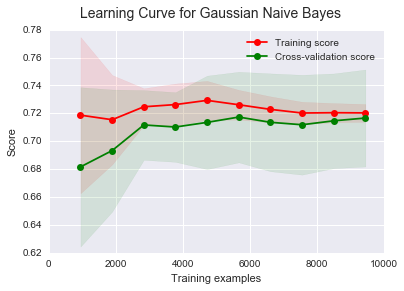

In [13]:
# Learning curve for Gaussian Naive Bayes
clf = GaussianNB()
cl.LearningCurve(clf, features, labels)
plt.suptitle('Learning Curve for Gaussian Naive Bayes', size=14)
plt.savefig('../working/learning_curve_nb.png')

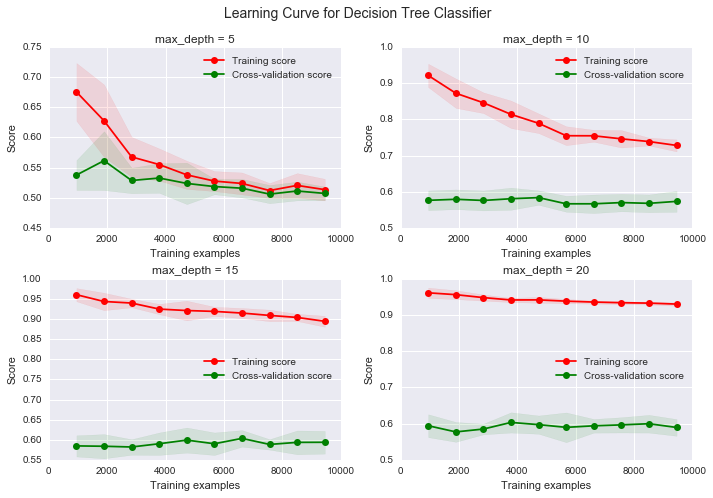

In [14]:
# Learning curve for Decision Tree Classifier
fig = plt.figure(figsize=(10,7))
max_depth = [5, 10, 15, 20]
for k, depth in enumerate(max_depth):
    clf = DecisionTreeClassifier(max_depth = depth)
    fig.add_subplot(2, 2, k+1)
    plt.title('max_depth = %s'%(depth))
    cl.LearningCurve(clf, features, labels)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.show()
plt.suptitle('Learning Curve for Decision Tree Classifier', size=14)
plt.savefig('../working/learning_curve_dt.png')

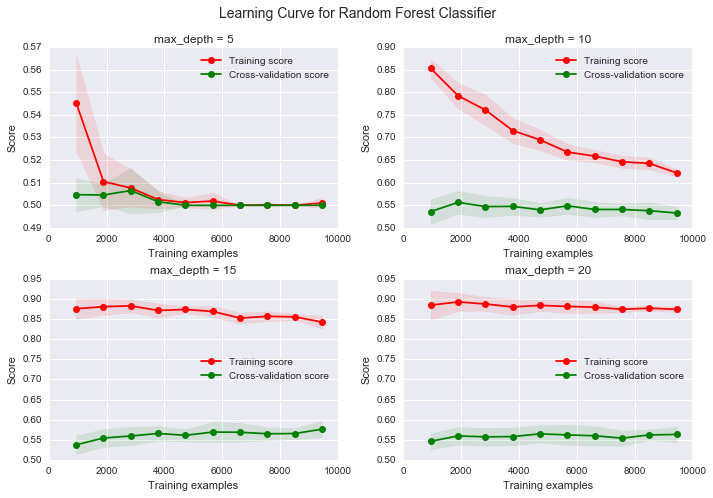

In [15]:
# Learning curve for Random Forest Classifier
fig = plt.figure(figsize=(10,7))
max_depth = [5, 10, 15, 20]
for k, depth in enumerate(max_depth):
    clf = RandomForestClassifier(max_depth = depth)
    fig.add_subplot(2, 2, k+1)
    plt.title('max_depth = %s'%(depth))
    cl.LearningCurve(clf, features, labels)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.show()
plt.suptitle('Learning Curve for Random Forest Classifier', size=14)
plt.savefig('../working/learning_curve_rf.png')

### Model Refinement
Apply SelectKBest to 44 features and select the number of features that gives the best model performance.

Best score: 0.724110758887
best parameters: {'feature_selection__k': 25}


C:\Users\Kiyoko\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [20 21] are constant.
  UserWarning)


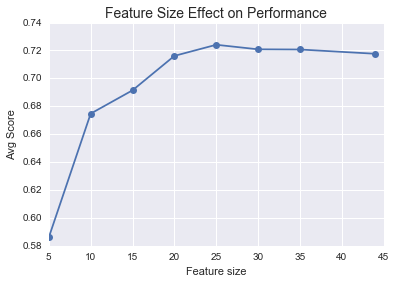

In [16]:
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

cv = ShuffleSplit(features.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)
clf = GaussianNB()
select = SelectKBest()
steps = [('feature_selection', select), ('nb', clf)]
parameters = dict(feature_selection__k=[5,10,15,20,25,30,35,'all'])
pipeline = Pipeline(steps)
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring=scorer)
grid_search.fit(features, labels)
print 'Best score: {}'.format(grid_search.best_score_)
print 'best parameters: {}'.format(grid_search.best_params_)

# plot feature size vs score
scores = [x[1] for x in grid_search.grid_scores_]
feature_sizes = [5,10,15,20,25,30,35,44]
plt.plot(feature_sizes, scores, 'o-')
plt.title('Feature Size Effect on Performance', size=14)
plt.xlabel('Feature size')
plt.ylabel('Avg Score')
plt.savefig('../working/gridsearch.png')

### The Final Model

In [17]:
# Select 25 best features
display(features.shape)
select = SelectKBest(k=25)
features = select.fit_transform(features, labels)
display(features.shape)

# Model with 25 features
alg = GaussianNB()
cv = ShuffleSplit(features.shape[0], n_iter = 10, test_size = 0.4, random_state = 0)
scorer = make_scorer(roc_auc_score)
score = cross_val_score(clf, features, labels, cv=cv, scoring=scorer)
print 'Avg Score: {:.2f}'.format(score.mean())

(10506L, 44L)

(10506L, 25L)

Avg Score: 0.73


### Verify results
Check for overfitting (score dependency on the training/testing subsets) and repeatability.

Model is repeatable indicated by a normal distribution of the score, with the mean of ~0.72.

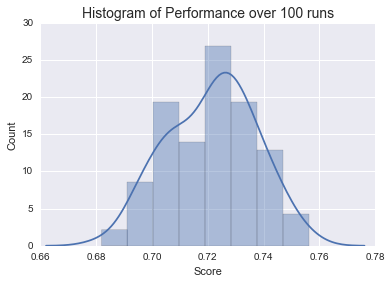

In [18]:
### check for overfitting (score dependency on the training/testing subsets)
clf = GaussianNB()
model_accuracies = []
for repetition in range(100):
    (features_train, features_test, labels_train, labels_test) = train_test_split(features, labels, train_size=0.6)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    score = roc_auc_score(labels_test, pred)
    model_accuracies.append(score)

sns.distplot(model_accuracies)
plt.title('Histogram of Performance over 100 runs', size=14)
plt.xlabel('Score')
plt.ylabel('Count')
plt.savefig('../working/model_accuracy.png')

### Visualize ROC Curve

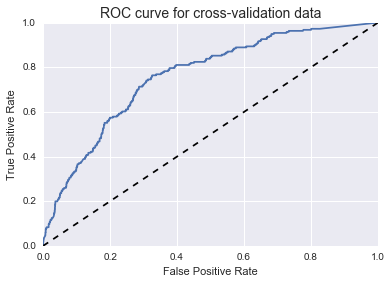

In [19]:
from sklearn.metrics import roc_curve, auc

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict_proba(features_test)[:,1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(labels_test, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for cross-validation data', size=14)
plt.savefig('../working/roc_curve.png')

### Compare the model performance against Kaggle's Leaderboard

count    1305.000000
mean        0.721460
std         0.092704
min         0.377900
25%         0.692270
50%         0.735550
75%         0.793590
max         0.890910
Name: Score, dtype: float64

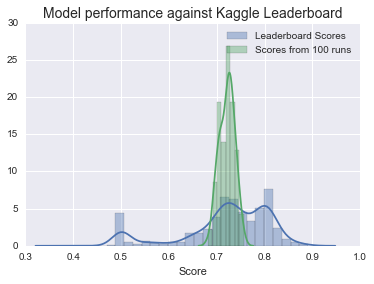

In [20]:
# Kaggle's public leaderboard database for the benchmark
data = pd.read_csv('../input/predict-west-nile-virus_public_leaderboard.csv')

teams = data.groupby(['TeamName'])
max_scores = teams['Score'].max()

display(max_scores.describe())
sns.distplot(max_scores, label='Leaderboard Scores')
sns.distplot(model_accuracies, label='Scores from 100 runs')
plt.title('Model performance against Kaggle Leaderboard', size=14)
plt.legend()
plt.savefig('../working/leaderboard.png')